# Navigation Real Data

In [3]:
library(DBI)
library(RPostgreSQL)
library(RPostgres)
library(alluvial)
install.packages("dplyr")
library(dplyr)


The downloaded binary packages are in
	/var/folders/jp/hxfthgjs52s2zpwdvlvtwj_c0000gp/T//RtmpEh0he6/downloaded_packages


In [4]:
setwd('/Users/florenceclutha/Desktop')
getwd()

[1] "/Users/florenceclutha/Desktop"

In [6]:
con <- dbConnect(RPostgres::Postgres(),
                 host="bi-redshift.prod.lostmy.name",
                 port=5439,
                 dbname="bi",                 
                 user="lmn_bi",
                 password="8ywD0NvE3q08")
dbListTables(con)
# dbDisconnect(con)

[1] "bi_updates"                  "item_with_giftwrap"         
 [3] "page_nth"                    "bi_updates_carmen"          
 [5] "rampup"                      "rampupyoy"                  
 [7] "orders_multiple_experiments" "orders_multiple_variations" 
 [9] "none"                        "tmp_addons"                 
[11] "adspend"                     "chains"                     
[13] "crossed"                     "rolling"

In [8]:
# SQL QUERY for SQL Workbench
# drop table if exists analysis.navigation_alluvial;
# create table analysis.navigation_alluvial as

# WITH last_event AS
# (
#   SELECT DISTINCT *,
#          (page_number + 1) AS next_page_number
#   FROM (SELECT tfp.session_id,
#                dse.category,
#                dse.action,
#                dse.label,
#                tfp.page_number,
#                ses.event_number,
#                RANK() OVER (PARTITION BY tfp.session_id,tfp.page_number ORDER BY ses.event_number DESC) AS last_event
#         FROM truth.fact_pages tfp
#           JOIN truth.dim_pages tdp ON tfp.page_fk = tdp.key
#           LEFT JOIN session.events ses
#                  ON tfp.session_id = ses.session_id
#                 AND tfp.page_number = ses.page_number
#           LEFT JOIN truth.dim_sessionevents dse ON ses.sessionevent_fk = dse.key
#         WHERE dse.category IN ('Header Navigation','Footer Navigation'))
#   WHERE last_event = 1
# ),
# page_tag AS
# (
#   SELECT DISTINCT tfp.session_id,
#          tdp.query_params,
#          tfp.page_number,
#          (tfp.page_number - 1) AS previous_page_number
#   FROM truth.fact_pages tfp
#     JOIN truth.dim_pages tdp ON tfp.page_fk = tdp.key
#   WHERE tdp.query_params LIKE '%%int_id%%'
# ),
# session_path AS
# (
#   SELECT tfp.session_id,
#          tfp.session_start_timestamp,
#          page_tag.query_params AS int_param,
# --          last_event.category || '/' || last_event.action || '/' || last_event.label AS last_event,
# --          last_event.category || '/' || last_event.action AS last_event,
#          last_event.category AS last_event, #chinese characters create errors if use any more than the category. 
#          tdp.page_type,
#          LEAD(tdp.page_type,1) OVER (PARTITION BY tfp.session_id ORDER BY tfp.page_number) AS following_page_type,
#          tfp.device_fk,
#          tfp.country_fk,
#          case when tfo.is_completed = 'true' then 1 else 0 end as converted_session
#   FROM truth.fact_pages tfp
#     JOIN truth.dim_pages tdp ON tfp.page_fk = tdp.key
#     LEFT JOIN page_tag
#            ON tfp.session_id = page_tag.session_id
#           AND tfp.page_number = page_tag.previous_page_number
#     LEFT JOIN last_event
#            ON tfp.session_id = last_event.session_id
#           AND tfp.page_number = last_event.page_number
#     LEFT JOIN truth.fact_orders tfo on tfp.conversion_number = tfo.order_number          
# )
# SELECT distinct session_id,
#        CASE
#          WHEN page_type IS NULL THEN 'entrance'
#          ELSE page_type
#        END AS page_type,
#        COALESCE(int_param,last_event,'other_interaction') AS interactional_navigation,
#        CASE
#          WHEN following_page_type IS NULL THEN 'exit'
#          ELSE following_page_type
#        END AS following_page_type,
#        converted_session,
#        tdd.name as device,
#        tdc.name as country
# FROM session_path
# left join truth.dim_devices tdd on session_path.device_fk = tdd.key
# left join truth.dim_countries tdc on session_path.country_fk = tdc.key
# WHERE session_start_timestamp >= '2017-12-01'
# AND   session_start_timestamp <= '2017-12-02'
# AND   page_type IN ('homepage','productspage') ;


In [9]:
query <- "select * from analysis.navigation_alluvial"

In [10]:
raw_data <- dbGetQuery(con,query)

In [11]:
head(raw_data)

session_id,page_type,interactional_navigation,following_page_type,converted_session,device,country
10048229420344681051512144824,homepage,other_interaction,exit,0,tablet,United States
10155261680398575801512119724,productspage,other_interaction,productspage,0,desktop,Switzerland
10250011192955042441512129238,homepage,other_interaction,exit,0,mobile,Japan
10332055419204344941512171838,homepage,other_interaction,product,0,mobile,United States
10434155338814855681512139008,productspage,other_interaction,exit,0,desktop,United States
10596004781838986291512103013,productspage,other_interaction,product,0,mobile,Australia


## Reading CSV

In [12]:
# df_nav = read.csv("navigation.csv",header=TRUE)
# head(df_nav)

In [13]:
# df_nav2 = read.csv("navigation2.csv",header=TRUE)
# head(df_nav2)

## Tidying Data

In [14]:
# http://genomicsclass.github.io/book/pages/dplyr_tutorial.html
raw_data_nav <- (raw_data %>%
                    group_by(page_type,interactional_navigation,following_page_type) %>%
                    summarise(sum_event = sum(converted_session),
                    total_sessions = n_distinct(session_id)
                              )
                 )
raw_data_nav2 <- (raw_data_nav %>%
                    group_by(page_type,interactional_navigation,following_page_type) %>%
#                     mutate(freq = paste0(round(100*sum_event / total_sessions,2),"%"))
                    mutate(cvr = round(100*sum_event / total_sessions,2))                  
                  )

                  
head(raw_data_nav2)


page_type,interactional_navigation,following_page_type,sum_event,total_sessions,cvr
homepage,Footer Navigation,account,0,1,0.00
homepage,Footer Navigation,blog,1,3,33.33
homepage,Footer Navigation,checkout,0,1,0.00
homepage,Footer Navigation,exit,0,21,0.00
homepage,Footer Navigation,helpville,4,59,6.78
homepage,Footer Navigation,homepage,0,17,0.00


In [15]:
head(raw_data_nav)

page_type,interactional_navigation,following_page_type,sum_event,total_sessions
homepage,Footer Navigation,account,0,1
homepage,Footer Navigation,blog,1,3
homepage,Footer Navigation,checkout,0,1
homepage,Footer Navigation,exit,0,21
homepage,Footer Navigation,helpville,4,59
homepage,Footer Navigation,homepage,0,17


## Graphing Data

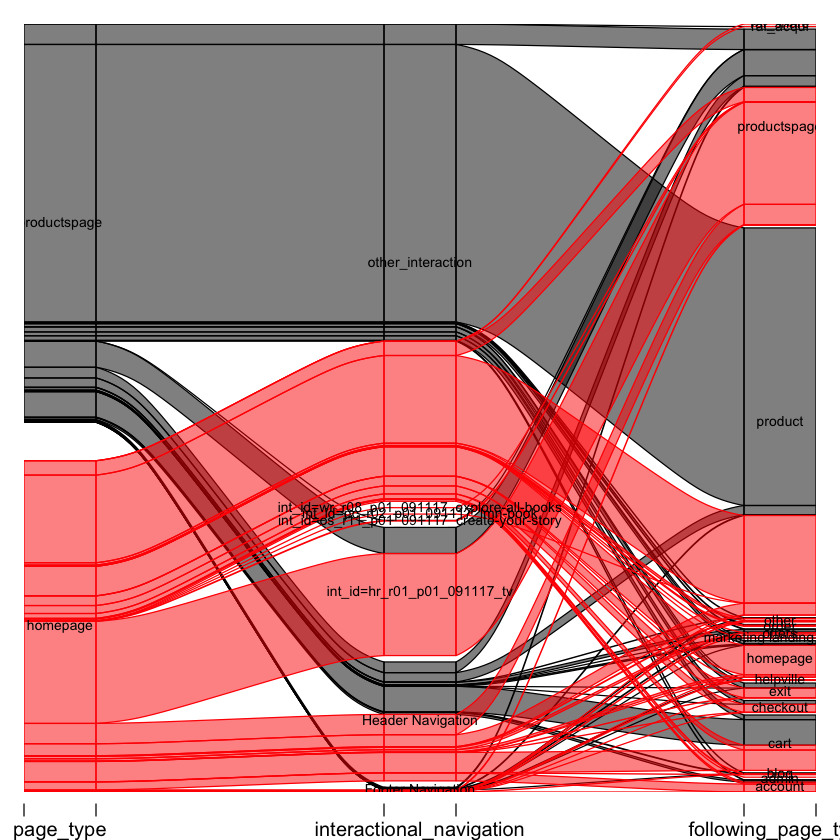

In [16]:
# https://cran.r-project.org/web/packages/alluvial/vignettes/alluvial.html#customizing-colors
alluvial( raw_data_nav2[,1:3], 
            freq=raw_data_nav2$sum_event, 
            col= ifelse(raw_data_nav2$page_type == "homepage", "red", "black"),
#             col= colorRampPalette(c("#c00000","#EABF4E","#248E46"))
            cex = 0.7, #font size relative to default
            alpha = 0.5,
            blocks = FALSE,
            border = ifelse(raw_data_nav2$page_type == "homepage", "red", "black"),
            layer = raw_data_nav2$page_type != "homepage"
        )

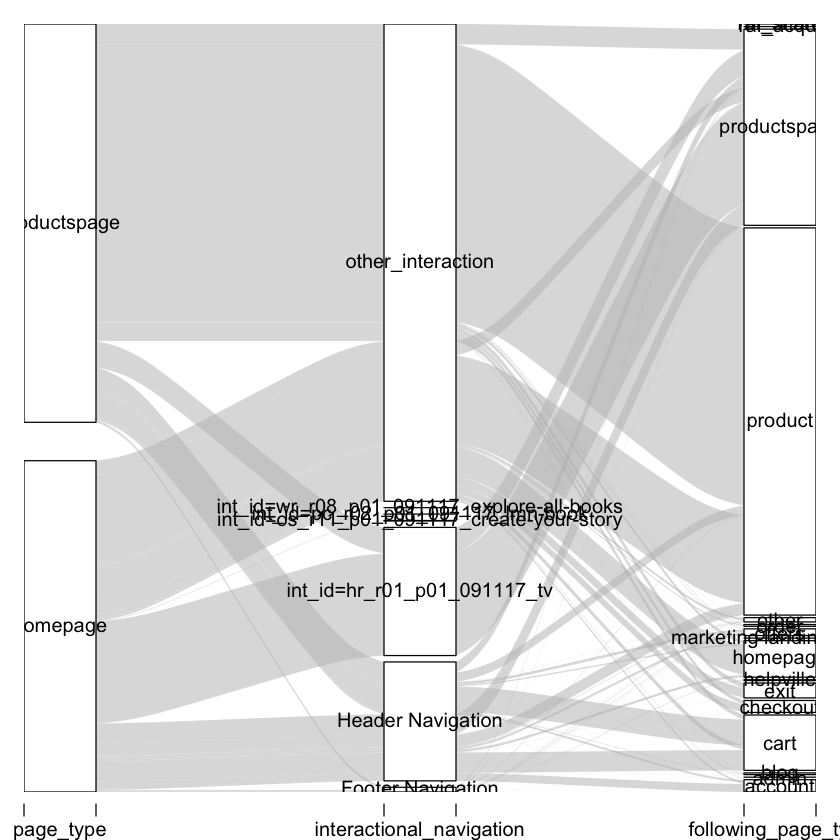

In [58]:
alluvial( raw_data_nav2[,1:3],
                     freq=raw_data_nav2$sum_event

        )

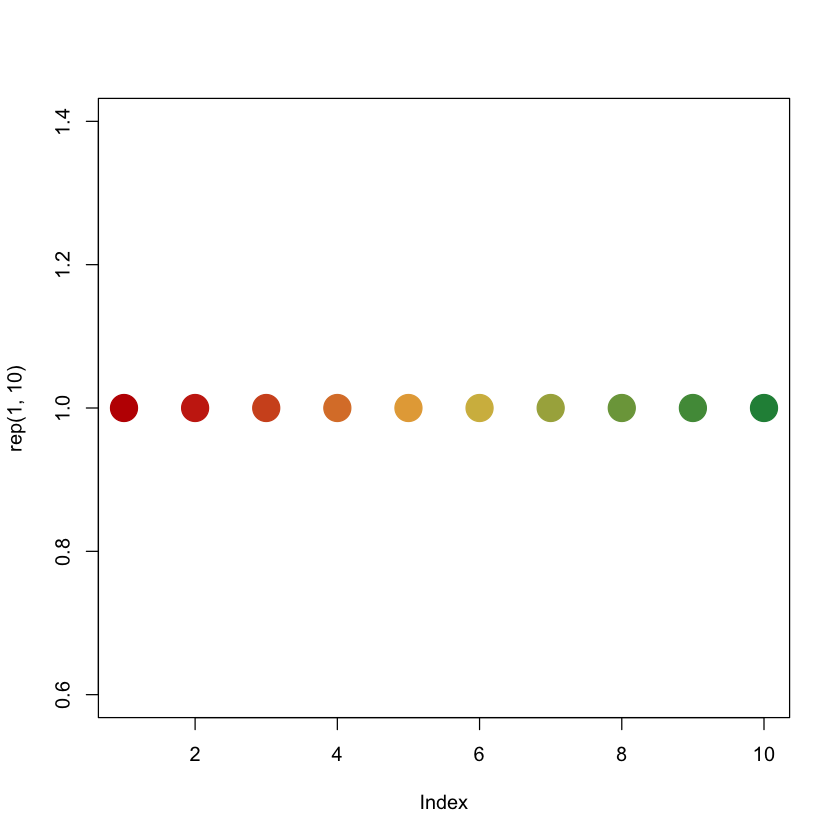

In [55]:
# trying to add colours to CVR good/bad
colfunc <-  colorRampPalette(c("#c00000","#EABF4E","#248E46"))#(length(raw_data$cvr))
plot(rep(1,10),col=colfunc(10),pch=19,cex=3)


In [17]:
# trying to create a loop so that the query can run for each device
for (device in unique(raw_data$device)) {
    print(device)
}

[1] "tablet"
[1] "desktop"
[1] "mobile"


# The rest of this book is just practicing

In [25]:
help(alluvial)

In [ ]:
df = read.table("fruits.txt", col.names = c('from', 'to'), sep=" ", )
df

In [ ]:
df_fruits = read.table("fruits2.txt", col.names = c('from', 'to', 'red', 'Freq'), sep=" ", )
df_fruits

In [ ]:
alluvial( df_fruits[,1:3], freq=df_fruits$Freq, border=NA,
#          hide = tit$Freq < quantile(tit$Freq, .50),
         col= "red"#ifelse( tit$Class == "3rd" & tit$Sex == "Male", "red", "gray") 
        )


In [ ]:
df_fruits2 <- aggregate(freq ~ from + to, data=df_fruits, sum)
df_fruits2


In [ ]:
alluvial( df_fruits2[,1:2], freq=df_fruits2$Freq, xw=0.0, alpha=0.8,
         gap.width=0.1, col= "steelblue", border="white",
         layer = df_fruits2$from != "lime" )

In [ ]:
alluvial( df[,1:2], freq=tit$from, border=NA,
         )

In [ ]:
help(alluvial)

In [ ]:
tit

In [ ]:
alluvial( tit[,1:2], freq=tit$Freq, border=NA,
#          hide = tit$Freq < quantile(tit$Freq, .50),
         col= "red"#ifelse( tit$Class == "3rd" & tit$Sex == "Male", "red", "gray") 
        )


In [ ]:
alluvial( tit[,1:2], freq=tit$Freq, border=NA,
#          hide = tit$Freq < quantile(tit$Freq, .50),
         col= "red"#ifelse( tit$Class == "3rd" & tit$Sex == "Male", "red", "gray") 
        )


## Titanic Example

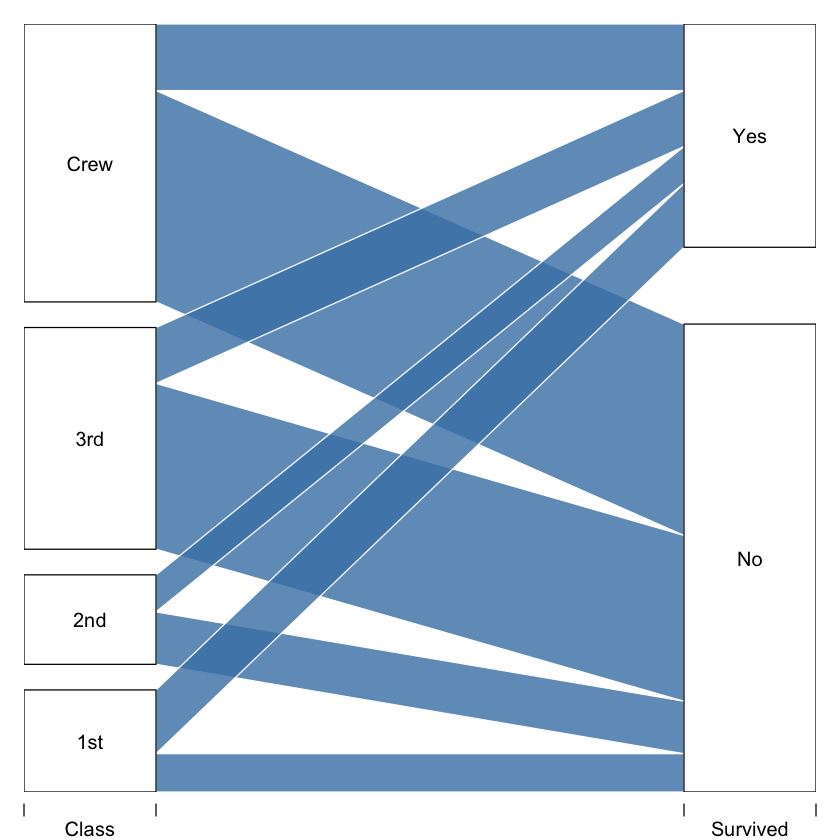

In [21]:
library(alluvial)
tit <- as.data.frame(Titanic)
 
# only two variables: class and survival status
tit2d <- aggregate( Freq ~ Class + Survived, data=tit, sum)
 
alluvial( tit2d[,1:2], freq=tit2d$Freq, xw=0.0, alpha=0.8,
         gap.width=0.1, col= "steelblue", border="white",
         layer = tit2d$Survived != "Yes" 
        )

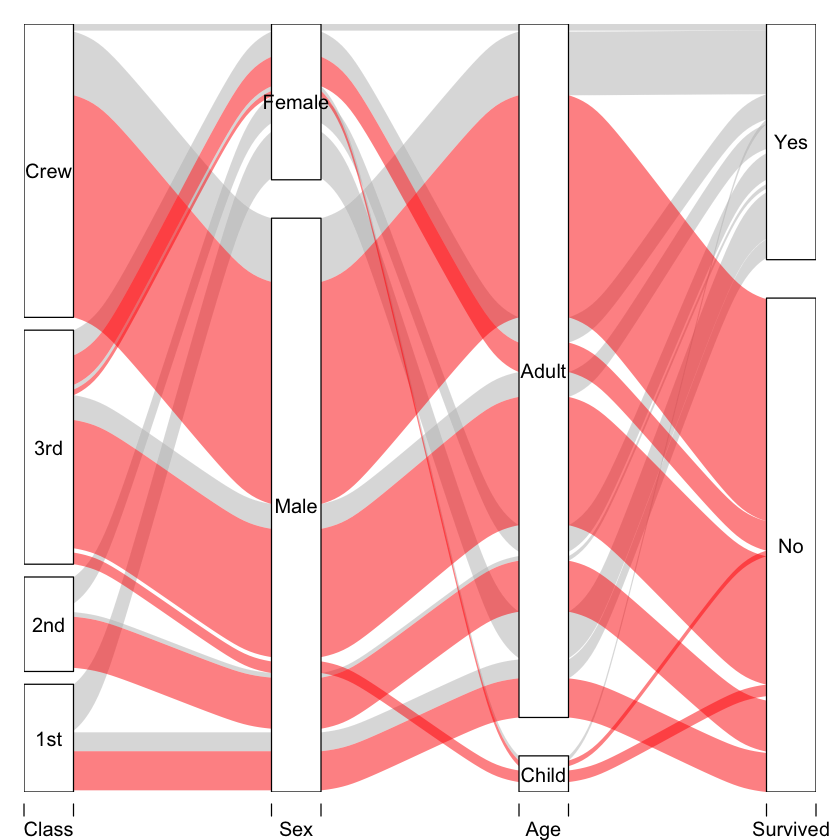

In [22]:
alluvial( tit[,1:4], freq=tit$Freq, border=NA,
         hide = tit$Freq < quantile(tit$Freq, .50),
         col=ifelse( tit$Survived == "No", "red", "gray"))